# Restauração de imagens

Material baseado no conteúdo das aulas de Moacir Ponti

## Ruído e remoção de ruído

Neste notebook lidamos com o problema de ruído nas imagens e o processo de denoising imagens com métodos de restauração de imagens.
A restauração de imagens preocupa-se em melhorar a qualidade visual das imagens, utilizando o conhecimento prévio sobre o processo que degradou a imagem, em particular o desfoque e o ruído. Em contraste com as técnicas de aprimoramento de imagem - nas quais um método é selecionado arbitrariamente para permitir a melhoria da qualidade das imagens - a restauração geralmente considera o processo de formação da imagem:

$$g(\mathbf{x}) = \mathcal{N} \left\lbrace f(\mathbf{x}) * h(\mathbf{x}) \right\rbrace,$$
          
onde $g$ é a imagem observada ou adquirida, $f$ é a imagem ideal ou original, $h$ é o filtro que explica a distorção causada na imagem para uma vizinhança centrada em $g(\mathbf {x})$, e $\mathcal{N}$ é um processo estocástico que explica o *ruído* na imagem $g(\mathbf {x})$.

**A restauração da imagem** é um processo para obter uma estimativa $\hat{f}$ da imagem original $f$

**Remoção de ruído de imagem**: lida com a reversão do processo de ruído. Para torná-lo mais matematicamente tratável, o processo de formação de imagem frequentemente considerado é aquele que assume ruído aditivo:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Distribuições de ruído e geração de ruído artificial
Vamos estudar algumas distribuições de ruído, que muitas vezes são modeladas por meio de alguma distribuição de probabilidade paramétrica, como, por exemplo:
* Uniforme: todos os intervalos de valores que podem ser adicionados à imagem são igualmente prováveis
* Gaussiano (normal): os valores a serem adicionados à imagem seguem uma distribuição normal, com alguma média (geralmente zero) e desvio padrão para que valores distantes da média sejam menos prováveis de ambos os lados (positivo e negativo)

Além do ruído que é dado por adição, também há processos de ruído não linear, por exemplo
* Impulsivo: representa um erro em um determinado pixel, transformando-o em valores específicos. Os mais comumente observados são os valores 0 (também conhecido como ruído de pimenta), 255 (também conhecido como ruído de sal) ou ambos (sal e pimenta). Portanto, isso considera apenas um conjunto limitado de valores possíveis, portanto, 'impulsivo'

Vamos começar com o ruído uniforme

In [2]:
def uniform_noise(size, prob=0.1):
    '''
    Gera uma matriz com ruído uniforme no intervalo [0-255] para ser adicionado a uma imagem
    
     : param size: tupla definindo o tamanho da matriz de ruído
     : param prob: probabilidade para a geração uniforme de ruído
     : tipo prob: float
     : matriz de retorno com ruído uniforme a ser adicionado à imagem
    '''
    
    levels = int((prob * 255) // 2)
    noise = np.random.randint(-levels, levels, size)
    
    return noise

In [3]:
img = cv2.imread("pattern2.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#imprime que a imagem tem apenas 3 valores de intensidade (quase preto, cinza escuro e cinza claro)
np.unique(img)

array([ 32, 127, 186], dtype=uint8)

In [4]:
uni_noise = uniform_noise(img.shape, prob=0.1)
#soma ruido à imagem
img_uni = np.clip(img.astype(int)+uni_noise, 0, 255)

hist_img,_ = np.histogram(img, bins=256, range=(0,255))
hist_uni,_ = np.histogram(img_uni, bins=256, range=(0,255))

<BarContainer object of 256 artists>

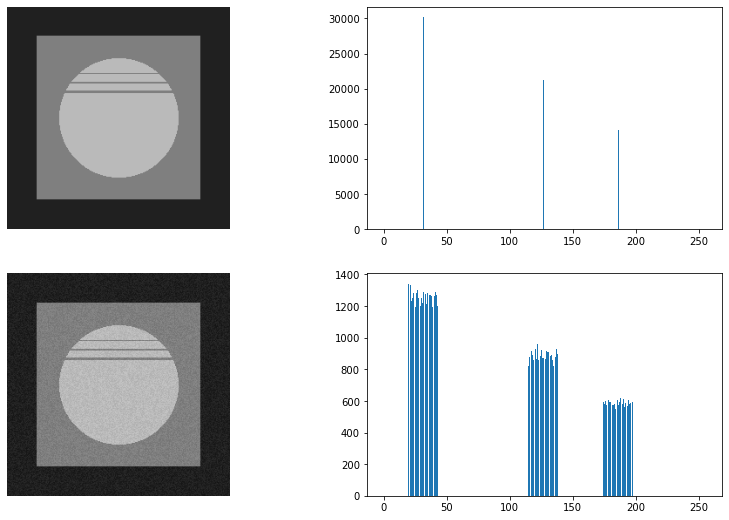

In [5]:
#Exibindo a imagem original e com ruído
plt.figure(figsize=(14,9))
plt.subplot(221)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(222)
plt.bar(np.arange(256), hist_img)
plt.subplot(223)
plt.imshow(img_uni, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(224)
plt.bar(np.arange(256), hist_uni)

Observe como a imagem original, que é livre de ruído, tem apenas três valores de intensidade (32, 127 e 186). Quando adicionamos ruído uniforme, os valores são adicionados (ou subtraídos) dessas intensidades, produzindo uma gama mais ampla de intensidades em torno dos valores originais. Observe como os valores são aproximadamente uniformes

In [6]:
#imprime os valores de intensidade na imagem que foi incluída o ruído
np.unique(img_uni)

array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197])

In [7]:
def gaussian_noise(size, mean=0, std=0.01):
    '''
    Gera uma matriz com ruído gaussiano no intervalo [0-255] para ser adicionado a uma imagem
    
     : param size: tupla definindo o tamanho da matriz de ruído
     : param mean: média da distribuição gaussiana
     : param std: desvio padrão da distribuição Gaussiana, padrão 0,01
     : matriz de retorno com ruído gaussiano a ser adicionado à imagem
    '''
    noise = np.multiply(np.random.normal(mean, std, size), 255)
    
    return noise

In [8]:
# creating the noise matrix to be added
gau_noise = gaussian_noise(img.shape, mean=0, std=0.05)


# adding and clipping values below 0 or above 255
img_gau = np.clip(img.astype(int)+gau_noise, 0, 255)

hist_gau,_ = np.histogram(img_gau, bins=256, range=(0,255))

<BarContainer object of 256 artists>

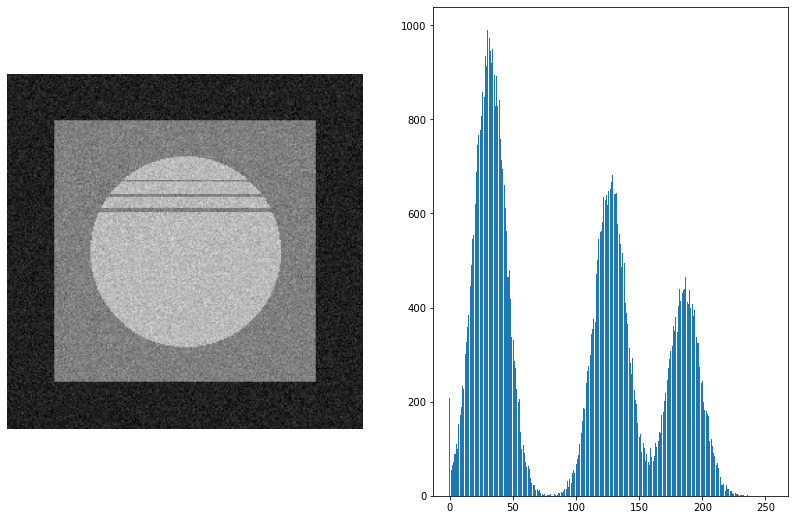

In [9]:
plt.figure(figsize=(14,9))
plt.subplot(121)
plt.imshow(img_gau, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.bar(np.arange(256), hist_gau)

No caso do ruído gaussiano, os valores são mais prováveis em torno dos valores de intensidade, que são a média da distribuição. Observe a forma do histograma.

In [10]:
def impulsive_noise(image, prob=0.1, mode='salt_and_pepper'):
    '''
    Retorna imagem com ruído impulsivo (0 e / ou 255) para substituir pixels na imagem com alguma probabilidade
    
     : imagem param: imagem de entrada
     : param prob: probabilidade para a geração de ruído impulsivo
     : modo param: tipo de ruído, 'sal', 'pimenta' ou 'salt_and_pepper' (padrão)
     : tipo prob: float
     : retorna imagem barulhenta com ruído impulsivo
    '''

    noise = np.array(image, copy=True)
    for x in np.arange(image.shape[0]):
        for y in np.arange(image.shape[1]):
            rnd = np.random.random()
            if rnd < prob:
                rnd = np.random.random()
                if rnd > 0.5:
                    noise[x,y] = 255
                else:
                    noise[x,y] = 0
    
    return noise

In [11]:
img_imp = impulsive_noise(img, prob=0.1)

hist_imp,_ = np.histogram(img_imp, bins=256, range=(0,255))

<BarContainer object of 256 artists>

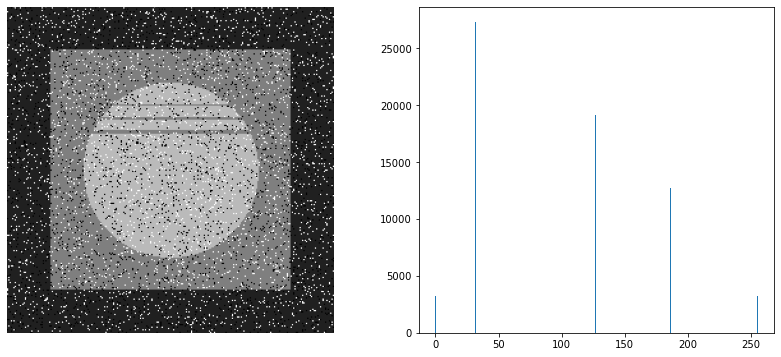

In [12]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(img_imp, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.bar(np.arange(256), hist_imp)

### Métodos de remoção de ruído

Em princípio, considerando uma formação de ruído aditiva, você poderia apenas gerar o ruído e subtraí-lo da imagem. No entanto, isso pode não produzir os resultados desejados. Portanto, filtros de suavização como o filtro *Gaussiano*, o filtro *Mediana* podem ser usados para reduzir a variância localmente na tentativa de diminuir o ruído das imagens.

In [13]:
# Gera ruído e subtrai da imagem original
uni_noise_new = uniform_noise(img.shape, prob=0.1)
img_uni_res = img_uni - uni_noise_new

def rmse(f,g):
    size = f.shape
    return np.sqrt(np.sum(np.square(f-g))/(size[0]*size[1]))

print("Erro entre ruído e original: %.3f%%" % (rmse(img.astype(float), img_uni.astype(float))))
print("Erro entre restaurada e original: %.3f%%" % (rmse(img_uni_res.astype(float), img.astype(float))))

Erro entre ruído e original: 6.946%
Erro entre restaurada e original: 9.794%


O erro aumentou em vez de diminuir, e visualizando as imagens confirmamos que na verdade ele adicionou mais ruído à imagem.

(-0.5, 255.5, 255.5, -0.5)

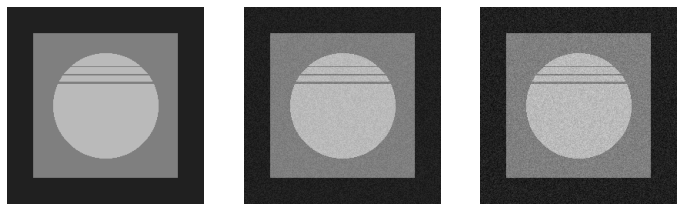

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(img_uni, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(img_uni_res, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

### Filtros de remoção de ruído

Vamos criar um filtro para diminuir o ruído. As opções são muitas, as mais utilizadas são a média, a Gaussiana e a mediana. A escolha do método depende do ruído

Todos os filtros de eliminação de ruído funcionam reduzindo a variação local.

In [15]:
# importing the fft algorithms
# including the transform, inverse and the shift methods
from scipy.fftpack import fftn, ifftn, fftshift

In [16]:
# reading a new image and inclucing gaussian noise
f = cv2.imread("moon2.jpg")
f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
#adiciona um ruido gaussiano na imagem
g = f + gaussian_noise(f.shape, mean=0, std=0.08)
g = np.clip(g.astype(int), 0, 255)

# creating a 7x7 mean filter
K = 7
w_mean = np.ones([K,K])/float(K*K)
#cria um filtro de transformada de fourier
def fft_imagefilter(g, w):
    ''' A function to filter an image g with the filter w
    '''
    # padding the filter so that it has the same size of the image
    pad1 = (g.shape[0]//2)-w.shape[0]//2
    wp = np.pad(w, (pad1,pad1-1), "constant",  constant_values=0)

    # computing the Fourier transforms
    W = fftn(wp)
    G = fftn(g)
    R = np.multiply(W,G)
    
    r = np.real(fftshift(ifftn(R)))
    return r

r_mean = fft_imagefilter(g, w_mean)

(-0.5, 255.5, 255.5, -0.5)

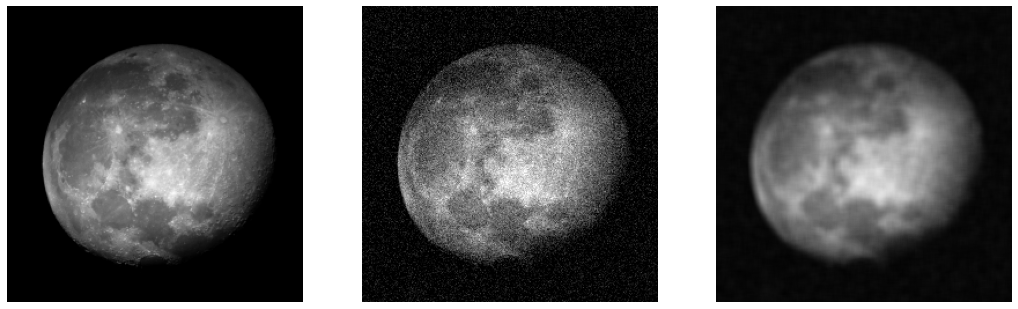

In [17]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(f, cmap="gray", vmin=0, vmax=255); plt.axis('off')
plt.subplot(132)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.axis('off')
plt.subplot(133)
plt.imshow(r_mean, cmap="gray", vmin=0, vmax=255); plt.axis('off')

In [18]:
def medianfilter(g, k):
    ''' Filtro da mediana com tamanho K
    '''
    a = k//2
    r = np.zeros(g.shape)
    for x in np.arange(a, g.shape[0]-a+1):
        for y in np.arange(a, g.shape[1]-a+1):
            med_region = np.median(g[x-a:x+a+1, y-a:y+a+1])
            r[x,y] = med_region
    
    return r

r_median = medianfilter(g,7)

Text(0.5, 1.0, 'median filter')

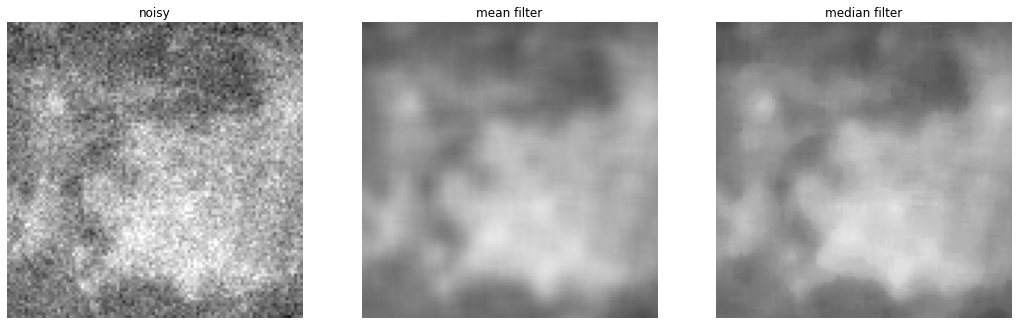

In [19]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(g[80:180,80:180], cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('noisy')
plt.subplot(132)
plt.imshow(r_mean[80:180,80:180], cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('mean filter')
plt.subplot(133)
plt.imshow(r_median[80:180,80:180], cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('median filter')

In [20]:
print ("Erro entre a média filtrada e o original:% .3f %%"% (rmse (f.astype (float), r_mean.astype (float))))
print ("Erro entre mediana-filtrada e original:% .3f %%"% (rmse (f.astype (float), r_median.astype (float))))

Erro entre a média filtrada e o original: 8.943 %
Erro entre mediana-filtrada e original: 6.548 %


Vamos fazer o mesmo, mas para uma imagem com ruído de sal e pimenta. Comparando um filtro de média e um filtro de mediana com tamanho 3 × 3

In [21]:
img_imp = impulsive_noise(img, prob=0.05)

w_mean3 = np.ones([3,3])/float(3*3)
img_mean = fft_imagefilter(img_imp, w_mean3)
img_median = medianfilter(img_imp, 3)

Text(0.5, 1.0, 'median filter')

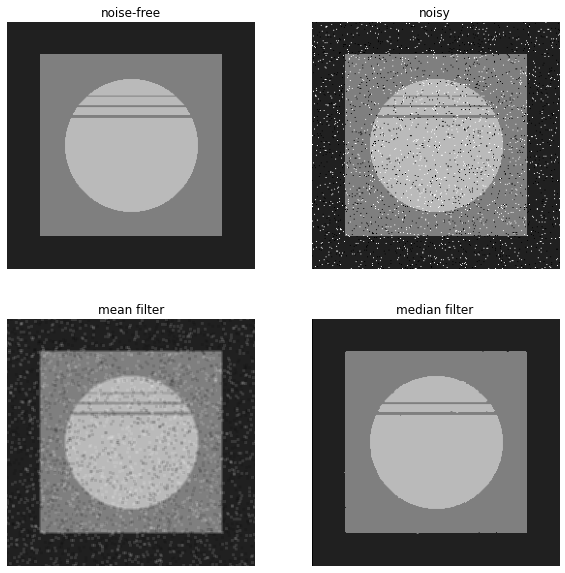

In [22]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(img, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('noise-free')
plt.subplot(222)
plt.imshow(img_imp, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('noisy')
plt.subplot(223)
plt.imshow(img_mean, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('mean filter')
plt.subplot(224)
plt.imshow(img_median, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('median filter')

Isso mostra como é relevante conhecer o processo de ruído antes de projetar um filtro para removê-lo.

## Blur - deconvolução

Podemos lidar com o problema da deconvolução da imagem, que é frequentemente aplicada para reduzir o efeito de **desfoque** na imagem.

A restauração de imagens preocupa-se em melhorar a qualidade visual das imagens usando o conhecimento prévio sobre o processo que degradou a imagem, em particular *desfoque* e *ruído*. Em contraste com as técnicas de aprimoramento de imagem - nas quais um método é selecionado arbitrariamente para permitir a melhoria da qualidade das imagens - a restauração geralmente considera o processo de formação da imagem:

$$g(\mathbf{x}) = \mathcal{N} \left\lbrace f(\mathbf{x}) * h(\mathbf{x}) \right\rbrace,$$
onde $g$ é a imagem observada ou adquirida, $f$ é a imagem ideal ou original, $h$ é o filtro que explica a distorção causada na imagem que é definida como um *espalhamento* de dados de um determinado pixel $f (\mathbf{x})$ para uma vizinhança centrada em $g (\mathbf {x}) $, e $\mathcal{N} $ é um processo estocástico que explica o *ruído* na imagem $ g(\mathbf {x}) $.

**Restauração de imagem** é um processo para obter uma estimativa $\hat{f}$ da imagem original $f$.

### Simulando um blur

Text(0.5, 1.0, 'degraded/blurred image')

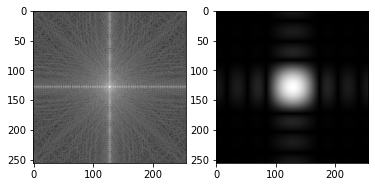

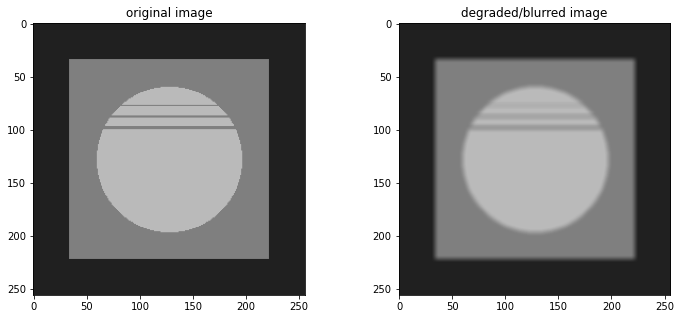

In [23]:
def gaussian_filter(k=5, sigma=1.0):
    ''' Gaussian filter
    :param k: defines the lateral size of the kernel/filter, default 5
    :param sigma: standard deviation (dispersion) of the Gaussian distribution
    :return matrix with a filter [k x k] to be used in convolution operations
    '''
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))
    return filt / np.sum(filt)


f = img
h = gaussian_filter(k=7, sigma=2.5)

# computing the number of padding on one side
a = int(f.shape[0]//2 - h.shape[0]//2)
h_pad = np.pad(h, (a,a-1), 'constant', constant_values=(0))

# computing the Fourier transforms
F = fftn(f)
H = fftn(h_pad)

plt.subplot(121)
plt.imshow(fftshift(np.log(np.abs(F)+1)), cmap="gray")
plt.subplot(122)
plt.imshow(fftshift(np.log(np.abs(H)+1)), cmap="gray")

# convolution
G = np.multiply(F,H)

# Inverse Transform
# - we have to perform FFT shift before reconstructing the image in the space domain
g = fftshift(ifftn(G).real)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(f, cmap="gray", vmin=0, vmax=255); plt.title("original image")
plt.subplot(122)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")

### Filtro inverso

O filtro inverso é uma tentativa de inverter o processo de convolução, obtendo uma estimativa da imagem original $\hat {f} $

$$\hat{F}(\mathbf{u}) = \frac{G(\mathbf{u})}{H(\mathbf{u})}$$

Observe que assumimos conhecimento sobre $ H $ ou a função de degradação. Portanto, conhecemos $h$ e $g$ e queremos reconstruir $f$.

Text(0.5, 1.0, 'restored image')

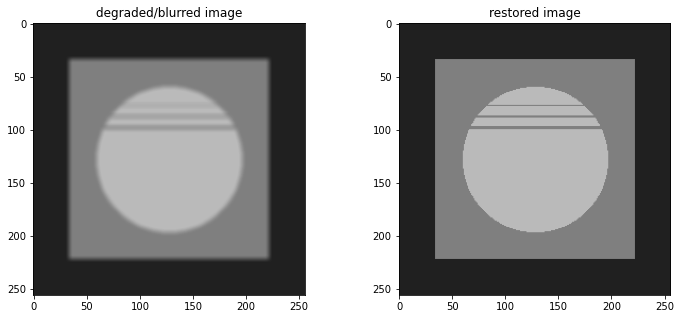

In [24]:
#F_hat = G/H
F_hat = np.divide(G,H)

f_hat = ifftn(F_hat).real

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.subplot(122)
plt.imshow(f_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored image")

Como podemos ver, os resultados do filtro inverso são muito bons! No entanto, assumimos um cenário sem ruído e uma função H bem comportada. 
Vejamos dois casos em que isso não funcionaria:

* Problema mal colocado: quando $h$ não tem uma inversa, ou sua transformada de Fourier H tem coeficientes zero, não podemos realizar o filtro inverso diretamente
* Ruído: quando a imagem é corrompida por ruído, este termo deve ser considerado na equação e causaria uma amplificação do ruído, uma vez que seu conteúdo está majoritariamente nas regiões de alta frequência do espectro de Fourier

## Notch Reject Filter

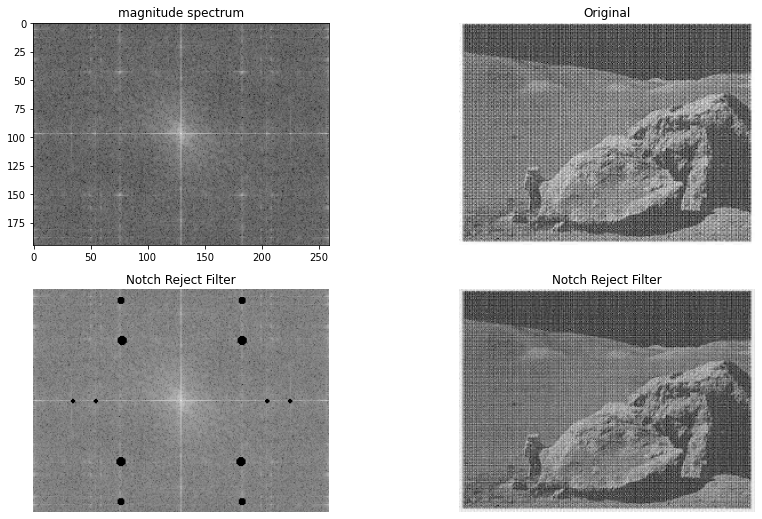

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#------------------------------------------------------
def notch_reject_filter(shape, d0=9, u_k=0, v_k=0):
    P, Q = shape
    # Initialize filter with zeros
    H = np.zeros((P, Q))

    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - P / 2 + u_k) ** 2 + (v - Q / 2 + v_k) ** 2)
            D_muv = np.sqrt((u - P / 2 - u_k) ** 2 + (v - Q / 2 - v_k) ** 2)

            if D_uv <= d0 or D_muv <= d0:
                H[u, v] = 0.0
            else:
                H[u, v] = 1.0

    return H
#-----------------------------------------------------

img_marte = cv2.imread("marte.jpg")
img = cv2.cvtColor(img_marte, cv2.COLOR_BGR2GRAY)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
phase_spectrumR = np.angle(fshift)
magnitude_spectrum = 20*np.log(np.abs(fshift))

img_shape = img.shape

H1 = notch_reject_filter(img_shape, 4, 53, 52)
H2 = notch_reject_filter(img_shape, 4, 53, -53)
H3 = notch_reject_filter(img_shape, 3, 88, 53)
H4 = notch_reject_filter(img_shape, 3, 88, -53)
H5 = notch_reject_filter(img_shape, 2, 0, 75)
H6 = notch_reject_filter(img_shape, 2, 0, 95)

#NotchFilter = H1*H2*H3*H4
NotchFilter = H1*H2*H3*H4*H5*H6
NotchRejectCenter = fshift * NotchFilter 
NotchReject = np.fft.ifftshift(NotchRejectCenter)
inverse_NotchReject = np.fft.ifft2(NotchReject)  # Compute the inverse DFT of the result


Result = np.abs(inverse_NotchReject)

plt.figure(figsize=(14,9))
plt.subplot(222)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off');
plt.subplot(221)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('magnitude spectrum')

plt.subplot(223)
plt.imshow(magnitude_spectrum*NotchFilter, "gray") 
plt.title("Notch Reject Filter")
plt.axis('off');
plt.subplot(224)
plt.imshow(Result, "gray") 
plt.title("Notch Reject Filter")
plt.axis('off');

## Aguçamento de imagens

1) Borrar a imagem original

2) Subtrair a imagem borrada da original

3) Adicionar a matriz obtida em (2) à imagem original.

In [33]:
img_raiox = cv2.imread("raiox.jpg")
img_raiox.shape

img_gray = cv2.cvtColor(img_raiox, cv2.COLOR_BGR2GRAY)

#Borrar a imagem original
# ksize
ksize = (10, 10)
  
# Using cv2.blur() method 
img_blur = cv2.blur(img_gray, ksize) 
  

#Subtrair a imagem borrada da original
img_sub = img_gray - img_blur

#Adicionar a matriz obtida antes à imagem original
img_nova= img_gray + img_sub

Text(0.5, 1.0, 'Imagem aguçada')

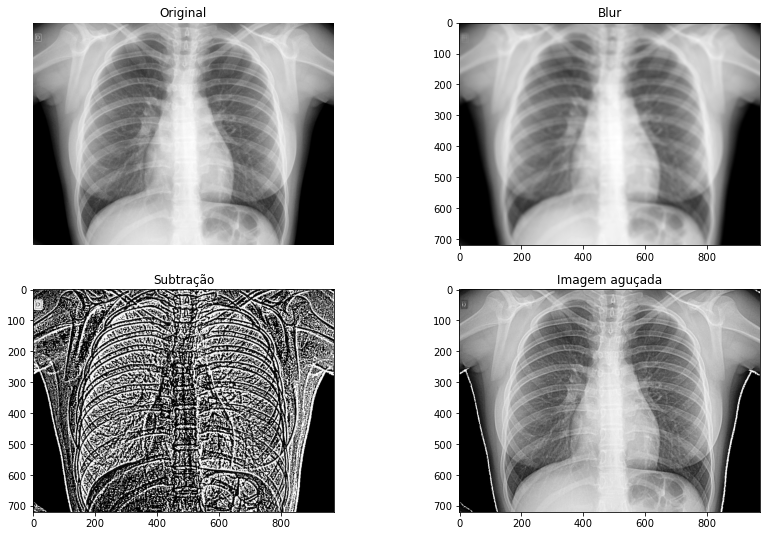

In [37]:
plt.figure(figsize=(14,9))
plt.subplot(221)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off');
plt.subplot(222)
plt.imshow(img_blur, cmap='gray')
plt.title('Blur')
plt.subplot(223)
plt.imshow(img_sub, cmap='gray')
plt.title('Subtração')
plt.subplot(224)
plt.imshow(img_nova, cmap='gray')
plt.title('Imagem aguçada')

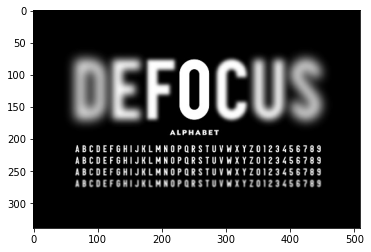

In [42]:
img_foco = cv2.imread("imagemBorrada.jpg")
img_foco.shape
plt.imshow(img_foco)

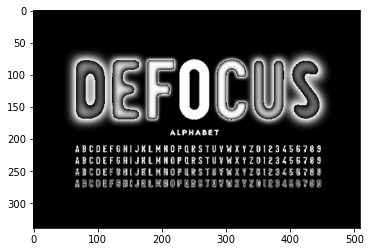

In [48]:
#adição de imagens
img_nova = img_foco + img_foco
plt.imshow(img_nova)

## Mais referências para Opencv

https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html

https://acervolima.com/python-denoising-de-imagens-coloridas-usando-opencv/

https://acervolima.com/python-desfocagem-de-imagem-usando-opencv/

https://acervolima.com/adicione-um-ruido-de-sal-e-pimenta-a-uma-imagem-com-python/